In [29]:
import logging, gensim
from gensim import corpora, models, similarities,matutils
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.datasets
import nltk
# nltk.download()
from nltk import word_tokenize
from nltk import sent_tokenize
import numpy as np
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords


%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

In [2]:
# Load Data
corpus = corpora.MmCorpus('20newsgroup.mm')
dictionary = corpora.Dictionary.load('20newsgroup.dict')

In [134]:
# ap.dat - Each document is one line with - N fieldId1:fieldValue1 fieldId2:fieldValue2 ... fieldIdN:fieldValueN
# The vocabulary is a file with words, one word per line; word at line K has an implicit id=K.
corpus = corpora.BleiCorpus('ap.dat','vocab.txt')

In [3]:
# Smaller alpha will result in fewer topics for each document
model = models.ldamodel.LdaModel(corpus,num_topics=100,id2word=corpus.id2word,alpha=1)

In [136]:
print(corpus)
# doc = corpus.docbyoffset(0)
# topics = model[doc]
# print(topics)

In [5]:
num_topics_used = [len(model[doc]) for doc in corpus]

(array([  56.,   89.,  224.,  424.,  764.,  484.,  144.,   44.,   11.,    6.]),
 array([  1. ,   5.7,  10.4,  15.1,  19.8,  24.5,  29.2,  33.9,  38.6,
         43.3,  48. ]),
 <a list of 10 Patch objects>)

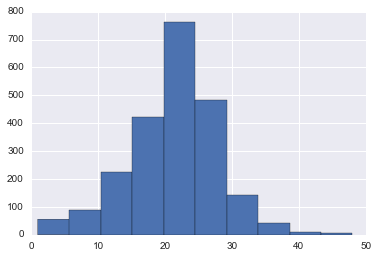

In [6]:
plt.hist(num_topics_used)

In [4]:
#train = sklearn.datasets.fetch_20newsgroups(subset='train',remove=('headers'))
train = sklearn.datasets.fetch_20newsgroups(subset='train')
test = sklearn.datasets.fetch_20newsgroups(subset='test')

In [98]:
#train.target_names
#train.filenames
#train.target[:10]
documents = train.data

In [ ]:
# nltk.download()
# test = word_tokenize(documents[1])
tokenizer = RegexpTokenizer(r'\w+')
s = nltk.stem.SnowballStemmer('english')
stop = stopwords.words('english')
texts = []

# [texts.append(set([s.stem(word) for sent in sent_tokenize(doc) for word in tokenizer.tokenize(sent) if word.lower() not in stop])) for doc in documents]

# stopwords are in lower case ... 
# for doc in documents:
#     for sent in sent_tokenize(doc):
#         texts.append([s.stem(word) for word in tokenizer.tokenize(sent) if word.lower() not in stop])

for doc in documents:
    texts.append([s.stem(word) for word in tokenizer.tokenize(doc) if word.lower() not in stop])

In [ ]:
# dictionary = corpora.Dictionary(line.lower().split() for line in open('mycorpus.txt'))
# Maps a word to a ID
dictionary = corpora.Dictionary(texts)
dictionary.save('20newsgroup.dict') # store the dictionary, for future reference
# print(dictionary)
# print(dictionary.token2id)

In [83]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('20newsgroup.mm', corpus) # store to disk, for later use
mm = corpora.MmCorpus('20newsgroup.mm')
# Word ID , Frequency for each document
print(mm)

MmCorpus(10 documents, 736 features, 956 non-zero entries)


In [84]:
tfidf = models.TfidfModel(corpus) # Initialize Tfidf
corpus_tfidf = tfidf[corpus] # Transform Test Corpus

# lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
# corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: corpus->tfidf->fold-in-lsi

lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=100)
# model = hdpmodel.HdpModel(bow_corpus, id2word=dictionary)

In [85]:
topics = lda_model[corpus_tfidf]

In [97]:
for i,t in enumerate(topics):
    print(dictionary.id2token[t[0][0]])
    print(documents[i])

keyword
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





oscil
From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Hos

(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

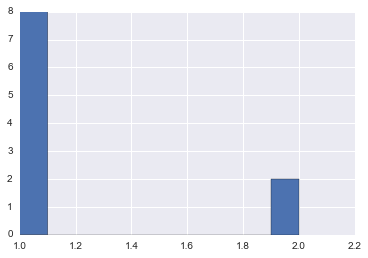

In [164]:
num_topics = [len(lda_model[doc]) for doc in corpus_tfidf]
plt.hist(num_topics)

In [86]:
# x = np.array([[1,2],[2,4]])
# print("x ",x.shape) - 2,2
# y = np.array([[1,2],[2,4]])
# print("x ",y.shape) 

x  (2, 2)


In [59]:
# s = nltk.stem.SnowballStemmer('english')
# class StemmedTfidfVectorizer(TfidfVectorizer):
#     def build_analyzer(self):
#         #StemmedCountVectorizer will return CountVectorizer build_analyzer code
#         analyzer = super(TfidfVectorizer,self).build_analyzer()
#         return lambda doc: (s.stem(w) for w in analyzer(doc))

# # default min_df = 1, max_df = 1.0
# # In other words, tf-idf weight in document that is
# # highest when the terms occurs many times within a small number of documents (thus lending high discriminating power to those documents);
# # lower when the term occurs fewer times in a document, or occurs in many documents (thus offering a less pronounced relevance signal);
# # lowest when the term occurs in virtually all documents.
# vectorizer = StemmedTfidfVectorizer(min_df=1,stop_words='english',decode_error='ignore')

# vectorized = vectorizer.fit_transform(documents)
# features = np.array(vectorizer.get_feature_names())
# # type(features)
# texts = [list(features[list((vectorized>0)[i].nonzero()[1])]) for i,doc in enumerate(documents)]